In [1]:
import numpy as np
import scipy
import copy
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl
from catboost.datasets import epsilon
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zero
%matplotlib inline

In [2]:
zero.__version__

'0.0.8'

In [3]:
def convert_relu_to_softplus(model, beta):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.Softplus(beta=beta))
        else:
            convert_relu_to_softplus(child, beta)
    return model

In [4]:
# set seed:
zero.improve_reproducibility(123456)

123456

In [6]:
columns = ["age", 
"workclass",
"fnlwgt",
"education",
"education-num",
"marital-status",
"occupation",
"relationship",
"race",
"sex",
"capital-gain",
"capital-loss",
"hours-per-week",
"native-country", 
"class"]

In [7]:
adult_tr = pd.read_csv("data/adult_income/adult.data", header=None, names=columns)
adult_te = pd.read_csv("data/adult_income/adult.test", header=None, names=columns, skiprows=[0])

In [8]:
inds_to_remove = adult_tr[(adult_tr["sex"]==" Female") & (adult_tr["class"]==" >50K")].index
adult_tr.drop(np.random.choice(inds_to_remove, size=500, replace=False), axis=0, inplace=True)

In [9]:
adult_tr[adult_tr["sex"]==" Female"]["class"].value_counts()

 <=50K    9592
 >50K      679
Name: class, dtype: int64

In [10]:
adult_all = pd.concat([adult_tr, adult_te], axis=0).reset_index()
adult_all.shape

(48342, 16)

In [11]:
ohe = OneHotEncoder()

In [12]:
a = ohe.fit_transform(adult_all[["workclass", "education", "marital-status", "occupation",
                                 "relationship", "race", "sex", "native-country"]])

In [13]:
adult_all_encoded = pd.DataFrame(a.todense(), columns=ohe.get_feature_names())

In [14]:
adult_all_encoded = pd.concat([adult_all[["class", "age", "fnlwgt", "capital-gain", 
                                          "capital-loss", "hours-per-week"]], 
                    adult_all_encoded], axis=1)

In [15]:
# adult_all_encoded["class"].value_counts()
adult_all_encoded["class"] = adult_all_encoded["class"].map(lambda x: x.strip()).map({"<=50K": 0, "<=50K.": 0,
                                                            ">50K": 1, ">50K.": 1})

In [16]:
adult_tr_encoded = adult_all_encoded.iloc[:adult_tr.shape[0]]
adult_te_encoded = adult_all_encoded.iloc[adult_tr.shape[0]:]

In [17]:
# normalization
normalizer = StandardScaler()
normalized_columns = normalizer.fit_transform(adult_tr_encoded[["age", "fnlwgt", "capital-gain", 
                                          "capital-loss", "hours-per-week"]])

In [18]:
adult_tr_encoded.loc[:,["age", "fnlwgt", "capital-gain", 
                        "capital-loss", "hours-per-week"]] = normalized_columns

/home/ahmad/anaconda3/envs/pytorch_robust_expls/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [19]:
normalized_columns_te = normalizer.transform(adult_te_encoded[["age", "fnlwgt", "capital-gain", 
                                          "capital-loss", "hours-per-week"]])
adult_te_encoded.loc[:, ["age", "fnlwgt", "capital-gain", 
                        "capital-loss", "hours-per-week"]] = normalized_columns_te

/home/ahmad/anaconda3/envs/pytorch_robust_expls/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [20]:
adult_te_encoded.to_csv("data/adult_income/test_enc_normalized.csv", index=False)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# data
task_type = "binclass"

X_tr = adult_tr_encoded.iloc[:, 1:].astype('float32')
y_tr = np.array(adult_tr_encoded.iloc[:, 0].astype('float32' if task_type == 'regression' else 'int64'))
#
X_te = adult_te_encoded.iloc[:, 1:].astype('float32')
y_te = np.array(adult_te_encoded.iloc[:, 0].astype('float32' if task_type == 'regression' else 'int64'))
# if task_type != 'regression':
#     y_tr = LabelEncoder().fit_transform(y_tr).astype('int64')
#     y_te = LabelEncoder().fit_transform(y_te).astype('int64')
n_classes = int(max(y_tr)) + 1 if task_type == 'multiclass' else None

X = {}
y = {}

X['test'] = X_te
y['test'] = y_te

X['train'], X['val'], y['train'], y['val'] = train_test_split(X_tr, y_tr, train_size=0.8, stratify=y_tr)

X = {
    k: torch.tensor(v.to_numpy(), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

In [23]:
d_out = n_classes or 1

model = rtdl.ResNet.make_baseline(
    d_in=X_tr.shape[1],
    d_main=339,
    d_hidden=348,
    dropout_first=0.2209100377552283,
    dropout_second=0.3058115601225451,
    n_blocks=8,
    d_out=d_out,
)
lr = 0.003479353084932105
weight_decay = 0.0

model.to(device)
optimizer = (
    model.make_default_optimizer()
    if isinstance(model, rtdl.FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
)
loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)

In [24]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


@torch.no_grad()
def evaluate(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 8192):
        prediction.append(apply_model(batch))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score


# Create a dataloader for batches of indices
# Docs: https://yura52.github.io/zero/reference/api/zero.data.IndexLoader.html
batch_size = 256
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

# Create a progress tracker for early stopping
# Docs: https://yura52.github.io/zero/reference/api/zero.ProgressTracker.html
progress = zero.ProgressTracker(patience=16)

print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 0.3837


In [26]:
n_epochs = 1000
report_frequency = len(X['train']) // batch_size // 5
for epoch in range(1, n_epochs + 1):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()
        if iteration % report_frequency == 0:
            print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

    val_score = evaluate('val')
    test_score = evaluate('test')
    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1 if task_type == 'regression' else 1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
        torch.save(model, "models/rtdl_resnet_adult_biased_female.pth")
    print()
    if progress.fail:
        break

(epoch) 1 (batch) 0 (loss) 0.7209
(epoch) 1 (batch) 20 (loss) 0.2989
(epoch) 1 (batch) 40 (loss) 0.2765
(epoch) 1 (batch) 60 (loss) 0.2803
(epoch) 1 (batch) 80 (loss) 0.3669
(epoch) 1 (batch) 100 (loss) 0.3396
Epoch 001 | Validation score: 0.8567 | Test score: 0.8482 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.3279
(epoch) 2 (batch) 20 (loss) 0.2765
(epoch) 2 (batch) 40 (loss) 0.2614
(epoch) 2 (batch) 60 (loss) 0.2710
(epoch) 2 (batch) 80 (loss) 0.3492
(epoch) 2 (batch) 100 (loss) 0.2864
Epoch 002 | Validation score: 0.8548 | Test score: 0.8456
(epoch) 3 (batch) 0 (loss) 0.3323
(epoch) 3 (batch) 20 (loss) 0.2729
(epoch) 3 (batch) 40 (loss) 0.2550
(epoch) 3 (batch) 60 (loss) 0.2761
(epoch) 3 (batch) 80 (loss) 0.3444
(epoch) 3 (batch) 100 (loss) 0.2765
Epoch 003 | Validation score: 0.8589 | Test score: 0.8491 <<< BEST VALIDATION EPOCH
(epoch) 4 (batch) 0 (loss) 0.3330
(epoch) 4 (batch) 20 (loss) 0.2837
(epoch) 4 (batch) 40 (loss) 0.2579
(epoch) 4 (batch) 60 (loss) 0.2695
(epoc

In [25]:
model = torch.load("models/rtdl_resnet_adult_biased_female.pth")
print(f'Test score after training: {evaluate("test"):.4f}')

Test score after training: 0.8514


In [26]:
model.eval()
prediction = []
for batch in zero.iter_batches(X["test"], 8192):
    prediction.append(apply_model(batch))
prediction = torch.cat(prediction).squeeze(1).detach().cpu().numpy()
prediction = np.round(scipy.special.expit(prediction))
target = y["test"].cpu().numpy()

In [27]:
print(sklearn.metrics.classification_report(target, prediction))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     12435
           1       0.70      0.65      0.67      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.78      0.79     16281
weighted avg       0.85      0.85      0.85     16281



In [28]:
adult_te["sex"].value_counts()

 Male      10860
 Female     5421
Name: sex, dtype: int64

In [29]:
adult_te["class"].value_counts()

 <=50K.    12435
 >50K.      3846
Name: class, dtype: int64

In [30]:
adult_te[adult_te["class"]==" >50K."]["sex"].value_counts()

 Male      3256
 Female     590
Name: sex, dtype: int64

In [31]:
x_test_male = copy.deepcopy(X["test"][(X_te["x6_ Male"]==1.0).values])
y_test_male = copy.deepcopy(y["test"][(X_te["x6_ Male"]==1.0).values])
##
model.eval()
pred_male = []
for batch in zero.iter_batches(x_test_male, 8192):
    pred_male.append(apply_model(batch))
pred_male = torch.cat(pred_male).squeeze(1).detach().cpu().numpy()
pred_male = np.round(scipy.special.expit(pred_male))
target_male = y_test_male.cpu().numpy()
##
print((pred_male == target_male).sum()/len(pred_male))

0.8128913443830571


In [32]:
np.unique(pred_male, return_counts=True)

(array([0., 1.], dtype=float32), array([7648, 3212]))

In [33]:
ids_pred_1 = (pred_male==1)

In [50]:
# female_test = adult_te_encoded[adult_te_encoded["x6_ Female"]==1.0]

In [309]:
# female_test["class"].value_counts()

In [310]:
# model.eval()
# prediction_fem = []
# for batch in zero.iter_batches(X["test"][(adult_te_encoded["x6_ Female"]==1.0).values], 8192):
#     prediction_fem.append(apply_model(batch))
# prediction_fem = torch.cat(prediction_fem).squeeze(1).detach().cpu().numpy()
# prediction_fem = np.round(scipy.special.expit(prediction_fem))
# target_fem = y["test"][(adult_te_encoded["x6_ Female"]==1.0).values].cpu().numpy()

In [61]:
# x_test_fem_pred0 = copy.deepcopy(X["test"][(X_te["x6_ Female"]==1.0).values][ids_pred_0])
# y_test_fem_pred0 = copy.deepcopy(y["test"][(X_te["x6_ Female"]==1.0).values][ids_pred_0])

In [34]:
id2column = {k:v for k,v in enumerate(X_tr.columns)}
column2id = {v:k for k,v in enumerate(X_tr.columns)}

In [35]:
x_test_male_pred1 = copy.deepcopy(x_test_male[ids_pred_1])
x_test_male_pred1[:, column2id["x6_ Male"]]=0.0
x_test_male_pred1[:, column2id["x6_ Female"]]=1.0
##
pred_male_changed=[]
for batch in zero.iter_batches(x_test_male_pred1, 8192):
    pred_male_changed.append(apply_model(batch))
pred_male_changed = torch.cat(pred_male_changed).squeeze(1).detach().cpu().numpy()
pred_male_changed = np.round(scipy.special.expit(pred_male_changed))

In [36]:
# 1 - spurious score
pred_male_changed.sum()/ len(pred_male_changed)

0.7306973848069739

#### view explanations

In [37]:
zero.improve_reproducibility(72)
BATCH_SIZE = 64
indices = np.random.randint(len(y["test"]), size=BATCH_SIZE)
#### load data #####
examples = X["test"][indices].to(device)
labels = y["test"][indices].to(device)
##
with torch.no_grad():
    if task_type=="binclass":
        preds = torch.tensor([1 if torch.sigmoid(l)>0.5 else 0 for l in model(examples).detach()]).to(device)
    else:
        preds = model(examples).argmax(dim=1).detach()
    samples_to_pick = (preds==labels)
    examples = examples[samples_to_pick]
    labels = labels[samples_to_pick]
###
examples = examples.requires_grad_(True)
###
print(examples.size())
BATCH_SIZE = examples.size()[0]

torch.Size([57, 107])


In [146]:
ind = 7
print(examples[ind][column2id["x6_ Female"]])
print(labels[ind])

tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [147]:
scipy.special.expit(apply_model(examples[ind:ind+1]).detach().cpu())

tensor([[0.0049]])

In [148]:
x_adv = torch.load("../examples/output_topk_tabular_data_adult/coordinate/x_integrated_grad.pth")

In [149]:
id2column[63]

'x6_ Female'

In [150]:
scipy.special.expit(apply_model(x_adv[ind:ind+1]).detach().cpu())

tensor([[0.0152]])

In [151]:
torch.sum(torch.abs(x_adv-examples) > 1e-12, dim=1)

tensor([ 6,  6,  6, 11,  5,  5,  6, 11,  6,  7,  5,  5,  8,  8,  7,  5,  7,  5,
        10,  5,  6,  6,  6,  8,  5,  8,  6,  6,  5,  6,  8,  9,  6,  7,  5,  6,
         6,  5,  8, 16, 13, 16, 15, 16, 15, 10, 14, 14, 13, 10, 15, 18,  5,  6,
         5,  5,  1], device='cuda:0')

In [152]:
from captum.attr import IntegratedGradients, Saliency, DeepLift

In [164]:
ig = IntegratedGradients(model, multiply_by_inputs=False)
# sm = Saliency(model)
# dl = DeepLift(model)

In [165]:
inds_to_keep = examples[ind:ind+1].squeeze().nonzero().squeeze()
inds_to_keep

tensor([ 0,  1,  2,  3,  4,  9, 22, 34, 45, 56, 62, 63, 91], device='cuda:0')

In [166]:
examples[ind][inds_to_keep]

tensor([ 0.4737,  0.0405, -0.1425, -0.2153, -0.0346,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [167]:
x_adv[ind][inds_to_keep]

tensor([-1.5736, -1.6698,  1.7823, -0.1000, -3.1895,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  0.8728,  1.0000,  0.0000], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [157]:
expl = ig.attribute(examples[ind: ind+1])
s = expl.argsort(descending=True).detach().cpu().squeeze().numpy()
s = [e for e in s if e in inds_to_keep]
expl_filtered = [expl[0,j].item() for j in s if torch.abs(expl[0,j]).item() > 0.0]
features = [id2column[j] for j in s if torch.abs(expl[0,j]).item() > 0.0]
print([t for t in zip(expl_filtered, features)])

[(0.7145773482880916, 'x1_ Assoc-voc'), (0.3557020931274431, 'age'), (0.3511675090013151, 'x5_ White'), (0.00011096860766130769, 'fnlwgt'), (-0.01423019520752305, 'hours-per-week'), (-0.060361968567478136, 'capital-loss'), (-0.26488436380110814, 'capital-gain'), (-0.3338024444431124, 'x0_ Private'), (-0.8107935998563056, 'x4_ Unmarried'), (-0.9884044391615755, 'x7_ Mexico'), (-1.098482714189999, 'x2_ Never-married'), (-1.4462011324075887, 'x6_ Female'), (-2.2752406551612974, 'x3_ Other-service')]


In [158]:
x_adv_c = copy.deepcopy(x_adv[ind:ind+1].detach())
x_adv_c[0][examples[ind:ind+1].squeeze().nonzero().squeeze()[5:]] += 1e-5
expl = ig.attribute(x_adv_c)
# expl[0,64] = expl[0,64] / 100
# expl[0, 2] = expl[0, 2] / 4
s = expl.argsort(descending=True).detach().cpu().squeeze().numpy()
s = [e for e in s if e in inds_to_keep]
expl_adv_filtered = [expl[0,j].item() for j in s if torch.abs(expl[0,j]).item() > 0.0]
features_adv = [id2column[j] for j in s if torch.abs(expl[0,j]).item() > 0.0]
print([t for t in zip(expl_adv_filtered, features_adv)])

[(5.700866528834034, 'capital-gain'), (0.3879232125231669, 'fnlwgt'), (0.19115870533418045, 'x5_ White'), (-6.096585338263286e-06, 'x0_ Private'), (-7.165647873753617e-06, 'x3_ Other-service'), (-8.652770840188258e-06, 'x4_ Unmarried'), (-1.1615095331175096e-05, 'x2_ Never-married'), (-1.2204601625797843e-05, 'x7_ Mexico'), (-0.03437864117149636, 'capital-loss'), (-0.05726789670008114, 'x6_ Female'), (-0.16193040032164852, 'x1_ Assoc-voc'), (-4.940606526772209, 'hours-per-week'), (-5.793784036638431, 'age')]


In [159]:
cat_to_name = {"x0": "work class:", "x1": "education:", "x2": "marital-status:",
              "x3": "occupation:", "x4": "relationship:", "x5": "race:", "x6": "gender:", "x7": "country:"}

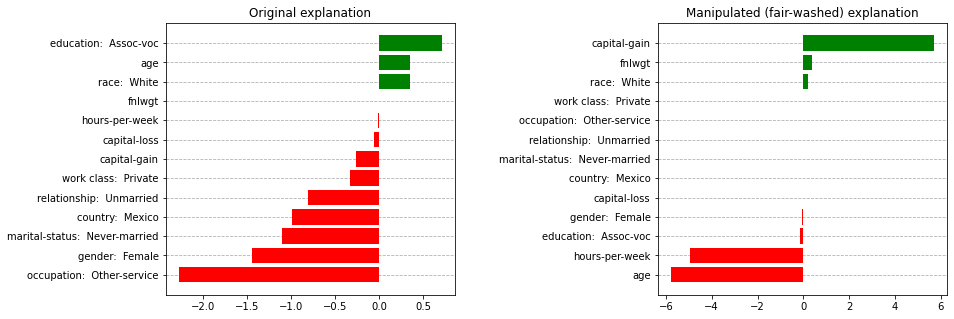

In [160]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
expl_filtered = expl_filtered[::-1]
features = features[::-1]
cs = ["green" if x>0 else "red" for x in expl_filtered]
ax[0].grid(axis="y", linestyle="--", zorder=0)
ax[0].barh(range(len(features)), expl_filtered, color=cs, zorder=3)
ax[0].set_yticks(range(len(features)))
names = [" ".join([cat_to_name[s.split("_")[0]], s.split("_")[1]]) if s.split("_")[0] in cat_to_name.keys() else s 
 for s in features ]
ax[0].set_yticklabels(names, rotation=0, fontsize=10)
ax[0].set_title("Original explanation", fontsize=12)
####
expl_adv_filtered = expl_adv_filtered[::-1]
features_adv = features_adv[::-1]
cs_adv = ["green" if x>0 else "red" for x in expl_adv_filtered]
ax[1].grid(axis="y", linestyle="--", zorder=0)
ax[1].barh(range(len(features_adv)), expl_adv_filtered, color=cs_adv, zorder=3)
ax[1].set_yticks(range(len(features_adv)))
names_adv = [" ".join([cat_to_name[s.split("_")[0]], s.split("_")[1]]) if s.split("_")[0] in cat_to_name.keys() else s 
 for s in features_adv ]
ax[1].set_yticklabels(names_adv, rotation=0, fontsize=10)
ax[1].set_title("Manipulated (fair-washed) explanation", fontsize=12)
plt.subplots_adjust(wspace=0.7);
# plt.savefig("biased_female_model_expl.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

In [161]:
adult_te.loc[indices[samples_to_pick.detach().cpu()][ind]]

age                           45
workclass                Private
fnlwgt                    194134
education              Assoc-voc
education-num                 11
marital-status     Never-married
occupation         Other-service
relationship           Unmarried
race                       White
sex                       Female
capital-gain                   0
capital-loss                   0
hours-per-week                40
native-country            Mexico
class                     <=50K.
Name: 1702, dtype: object

In [162]:
ind

7

In [163]:
examples[ind][inds_to_keep][4].detach().cpu().numpy() * normalizer.scale_[4] + normalizer.mean_[4]

39.999999977268125

In [85]:
x_adv[ind][inds_to_keep][4].detach().cpu().numpy() * normalizer.scale_[4] + normalizer.mean_[4]

2.7026686241672593

In [82]:
x_adv[ind][2]*normalizer.scale_[2] + normalizer.mean_[2]

tensor(19989.0781, device='cuda:0', grad_fn=<AddBackward0>)

In [78]:
normalizer

{'copy': True, 'with_mean': True, 'with_std': True}

In [416]:
X_te

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,x0_ ?,x0_ Federal-gov,x0_ Local-gov,x0_ Never-worked,x0_ Private,...,x7_ Portugal,x7_ Puerto-Rico,x7_ Scotland,x7_ South,x7_ Taiwan,x7_ Thailand,x7_ Trinadad&Tobago,x7_ United-States,x7_ Vietnam,x7_ Yugoslavia
32061,-0.988872,0.349591,-0.142610,-0.215585,-0.035069,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32062,-0.038536,-0.946381,-0.142610,-0.215585,0.773873,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32063,-0.769564,1.391654,-0.142610,-0.215585,-0.035069,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32064,0.400080,-0.279332,0.930759,-0.215585,-0.035069,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32065,-1.500592,-0.816934,-0.142610,-0.215585,-0.844011,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48337,0.034567,0.241903,-0.142610,-0.215585,-0.358646,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48338,1.862136,1.244562,-0.142610,-0.215585,-0.035069,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48339,-0.038536,1.751455,-0.142610,-0.215585,0.773873,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48340,0.400080,-1.002416,0.618996,-0.215585,-0.035069,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [229]:
x_adv[ind][45]

tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)

In [207]:
inds = torch.arange(examples.size()[1], device=device)
a1 = torch.cat([torch.nonzero(examples[i]).squeeze() for i in range(examples.size()[0])])
a0 = torch.cat([torch.ones(13, device=device, dtype=torch.int64)*i for i in range(examples.size()[0])])
all_inds = torch.stack([inds for _ in range(examples.size()[0])], dim=0)
all_inds[a0, a1] = -1
all_inds = all_inds[all_inds!=-1].view(all_inds.size()[0], -1)

In [209]:
all_inds.view(-1)

tensor([  5,   6,   7,  ..., 103, 105, 106], device='cuda:0')

In [95]:
[" ".join([cat_to_name[s.split("_")[0]], s.split("_")[1]]) if s.split("_")[0] in cat_to_name.keys() else s 
 for s in features ]

['education:  Assoc-voc',
 'age',
 'race:  White',
 'fnlwgt',
 'hours-per-week',
 'capital-loss',
 'capital-gain',
 'work class:  Private',
 'relationship:  Unmarried',
 'country:  Mexico',
 'marital-status:  Never-married',
 'gender:  Female',
 'occupation:  Other-service']

In [88]:
adult_te.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [137]:
print(scipy.special.expit(apply_model(X["test"][ind:ind+1]).detach().cpu()))
print(scipy.special.expit(apply_model(x_adv[-1:]).detach().cpu()))

tensor([[1.]])
tensor([[1.]])


In [86]:
id2column[64]

'x6_ Male'

In [188]:
X["test"][-1:][0,column2id["x6_ Male"]]

tensor(1., device='cuda:0')

In [51]:
X_te.iloc[-1] * normalizer.scale_

age                   -0.262580
fnlwgt                -0.072293
capital-gain          -0.145920
capital-loss          -0.216660
hours-per-week         1.584366
                         ...   
x7_ Thailand           0.000000
x7_ Trinadad&Tobago    0.000000
x7_ United-States      1.000000
x7_ Vietnam            0.000000
x7_ Yugoslavia         0.000000
Name: 48841, Length: 107, dtype: float32

In [57]:
1.584366 * normalizer.scale_[4] + normalizer.mean_[4]

60.000001637516164

In [55]:
normalizer.scale_

array([1.36402231e+01, 1.05548357e+05, 7.38517868e+03, 4.02954031e+02,
       1.23472391e+01])

In [56]:
adult_te

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [80]:
a = torch.tensor([[0, 1 ,0], [2, 1, 0]])
torch.nonzero(a, )

tensor([[0, 1],
        [1, 0],
        [1, 1]])